Reproduce Elis' work, for my understanding

It looks like the three relevant bits of code happen in three steps:
- Define the uNet
- straighten the images
- perform segmentation

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
class bcolors:
    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKCYAN = "\033[96m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

In [19]:
"""
Resize the images for training

"""
import pathlib
import warnings
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from cementum import processing

# We don't have the same number of images and masks, unfortunately
# So we'll just open this many
n_imgs = 256
n_total = 516

# TODO pick them at random

train_size = (320, 320)
data_dir = pathlib.Path("../data/original cut/")
mask_dir = pathlib.Path("../data/masks cut/")

img_paths = sorted(tuple(data_dir.glob(r"????.tif")))[:n_imgs]
full_size_images = [
    Image.open(str(path)) for path in img_paths
]  # We'll use these later
resized_images = [processing.resize(image, train_size) for image in full_size_images]

# Subtract 1 from masks to make them 0-indexed
mask_paths = sorted(tuple(pathlib.Path(mask_dir).glob(r"????.tif")))[:n_imgs]
resized_masks = [
    processing.resize(Image.open(str(path)), train_size) - 1 for path in mask_paths
]

# Check that the masks all contain the right values - and contain all of them (which might be unnecessary)
for i, mask in enumerate(resized_masks):
    assert (
        np.unique(mask) == [0, 1, 2]
    ).all(), f"{bcolors.FAIL}Mask {i} contains vals {bcolors.WARNING}{np.unique(mask)}"

assert len(resized_images) == len(resized_masks), len(resized_images)
if len(resized_images) != n_imgs:
    warnings.warn(
        f"{bcolors.WARNING}Only {len(resized_images)} images and {len(resized_masks)} masks were loaded"
    )
print(len(resized_masks))

256


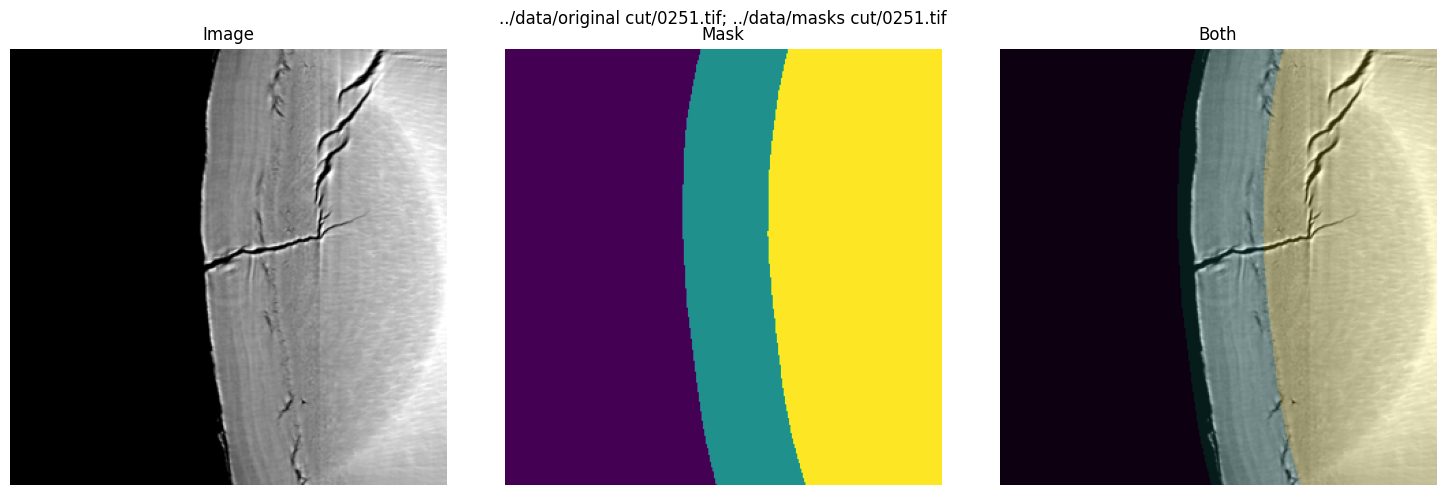

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
idx = -5
axes[0].imshow(resized_images[idx], cmap="grey")
axes[1].imshow(resized_masks[idx])

axes[2].imshow(resized_images[idx], cmap="gray")
axes[2].imshow(resized_masks[idx], alpha=0.2)

fig.suptitle(f"{img_paths[idx]}; {mask_paths[idx]}")

for axis, title in zip(axes, ("Image", "Mask", "Both")):
    axis.axis("off")
    axis.set_title(title)

fig.tight_layout()
fig.savefig("demo.png")

In [21]:
"""
Reshape, normalise and split the data
Also find the class weights

Some of this needs abstracting or encapsulating or something

"""
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split


def normalise_images(image: np.ndarray) -> np.ndarray:
    """
    Normalise an image or collection of images from 0-255 to 0-1

    """
    if np.issubdtype(image.dtype, np.integer):
        image = image / 255.0
    else:
        warnings.warn(f"{bcolors.WARNING}Image is not of integer type: {image.dtype}")

    return image


def flatten_masks(masks: list) -> np.ndarray:
    """Flatten a list of masks (or images) into a single column"""
    return np.array(masks).reshape(-1, 1)


def add_axis(images: list) -> np.ndarray:
    """
    Add an axis to an image or collection of images

    """
    return np.array(images)[..., np.newaxis]


def reshape_and_convert_to_categorical(y: np.ndarray, num_classes: int) -> np.ndarray:
    """Reshape the labels to match the input shape of the model and convert to categorical matrix"""
    y_cat = to_categorical(y, num_classes=num_classes)
    return y_cat.reshape((y.shape[0], y.shape[1], y.shape[2], num_classes))


# Flatten the training masks into one column
train_masks_reshaped = flatten_masks(resized_masks).ravel()

# Add another dimension to the training images
# This is required because the model expects images to have shape (batch_size, height, width, n_channels)
# n_channels = 1 here, becuase the images are greyscale
reshaped_images = add_axis(resized_images)
reshaped_masks = add_axis(resized_masks)

# Normalize images
reshaped_images = normalise_images(reshaped_images)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    reshaped_images, reshaped_masks, test_size=0.40, random_state=0
)

print(
    f"Class values in the dataset are ... , {dict(zip(*np.unique(y_train, return_counts=True)))}"
)

n_classes = len(np.unique(reshaped_masks))
assert (
    n_classes == 3
), "We've already checked this, so if this fails then you're in trouble"

# Convert the labels to categorical matrices
y_train_cat = reshape_and_convert_to_categorical(y_train, n_classes)
y_test_cat = reshape_and_convert_to_categorical(y_test, n_classes)

# Find class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_masks_reshaped),
    y=train_masks_reshaped,
)

class_weights = dict(zip(range(n_classes), class_weights))

print("Class weights are...:", class_weights)

Class values in the dataset are ... , {0: 5992359, 1: 3741953, 2: 5932888}
Class weights are...: {0: 0.8770495584992397, 1: 1.3803696568690562, 2: 0.8807701847143179}


In [22]:
"""
Define the uNet

"""
from cementum import unet
from keras.optimizers import Adam
from keras.metrics import Precision, Recall

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

model = unet.my_unet(
    n_classes=n_classes,
    IMG_HEIGHT=IMG_HEIGHT,
    IMG_WIDTH=IMG_WIDTH,
    IMG_CHANNELS=IMG_CHANNELS,
)

model.compile(
    optimizer=Adam(learning_rate=0.002),
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 320, 320, 16)         160       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 320, 320, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 320, 320, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

In [23]:
"""
Train the model

"""
import os
import pickle
from keras.models import load_model

# Probably want a batch_size of 32, 64 or 16
# More epochs will probably be better but might overfit
# Want to shuffle the data since nearby images are very similar
train_kw = {"batch_size": 32, "epochs": 25, "verbose": 1, "shuffle": True}

model_path = "cementum_test.keras"
history_path = "cementum_test.history"
if os.path.exists(model_path) and os.path.exists(history_path):
    model = load_model(model_path)
    with open(history_path, "rb") as history:
        history = pickle.load(history)
else:
    history = model.fit(
        X_train,
        y_train_cat,
        validation_data=(X_test, y_test_cat),
        class_weight=class_weights,
        **train_kw,
    )

    model.save(model_path)
    with open(history_path, "wb") as f:
        pickle.dump(history, f)

Epoch 1/25
5/5 [==============================] - 37s 7s/step - loss: 1.1662 - accuracy: 0.5219 - precision_1: 0.5949 - recall_1: 0.2767 - val_loss: 0.8713 - val_accuracy: 0.7633 - val_precision_1: 0.7224 - val_recall_1: 0.3667
Epoch 2/25
5/5 [==============================] - 34s 7s/step - loss: 0.8725 - accuracy: 0.7374 - precision_1: 0.6373 - recall_1: 0.2676 - val_loss: 0.8039 - val_accuracy: 0.7673 - val_precision_1: 0.6692 - val_recall_1: 0.3725
Epoch 3/25
5/5 [==============================] - 33s 7s/step - loss: 0.7990 - accuracy: 0.7623 - precision_1: 0.6370 - recall_1: 0.3437 - val_loss: 0.7036 - val_accuracy: 0.7746 - val_precision_1: 0.6558 - val_recall_1: 0.3816
Epoch 4/25
5/5 [==============================] - 34s 7s/step - loss: 0.8093 - accuracy: 0.7445 - precision_1: 0.6861 - recall_1: 0.5279 - val_loss: 0.6042 - val_accuracy: 0.7655 - val_precision_1: 0.7713 - val_recall_1: 0.7523
Epoch 5/25
5/5 [==============================] - 33s 7s/step - loss: 0.6153 - accuracy:

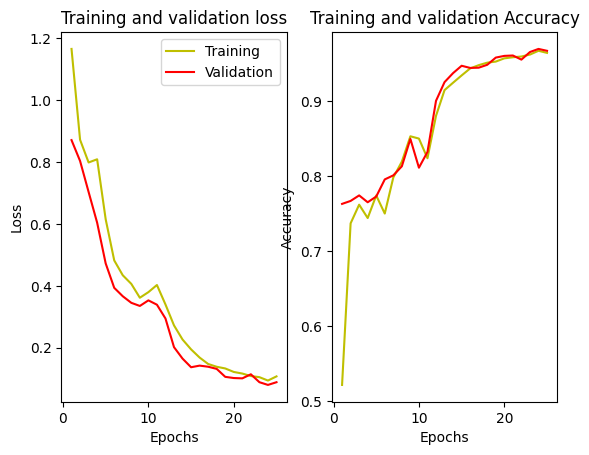

In [24]:
"""
Plot the loss and validation accuracy at each epoch

"""
loss = history.history["loss"]
val_loss = history.history["val_loss"]

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1, len(loss) + 1)

fig, axes = plt.subplots(1, 2)
axes[0].plot(epochs, loss, "y", label="Training")
axes[0].plot(epochs, val_loss, "r", label="Validation")
axes[0].set_title("Training and validation loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

axes[1].plot(epochs, acc, "y", label="Training")
axes[1].plot(epochs, val_acc, "r", label="Validation")
axes[1].set_title("Training and validation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[0].legend()

fig.savefig("training.png")

In [25]:
"""
Calculate intersection over union for each class using the test set

"""
from keras.metrics import MeanIoU

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:, :, :, 0], model.predict(X_test).argmax(axis=3))


def calculate_iou(values, class_idx):
    iou = values[class_idx, class_idx] / (
        values[class_idx, :].sum()
        + values[:, class_idx].sum()
        - values[class_idx, class_idx]
    )
    return iou


values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

for i in range(n_classes):
    class_iou = calculate_iou(values, i)
    print(f"IoU for class {i} is: ", class_iou)

4/4 [==============================] - 5s 998ms/step
IoU for class 0 is:  0.97983795
IoU for class 1 is:  0.87335193
IoU for class 2 is:  0.93691677


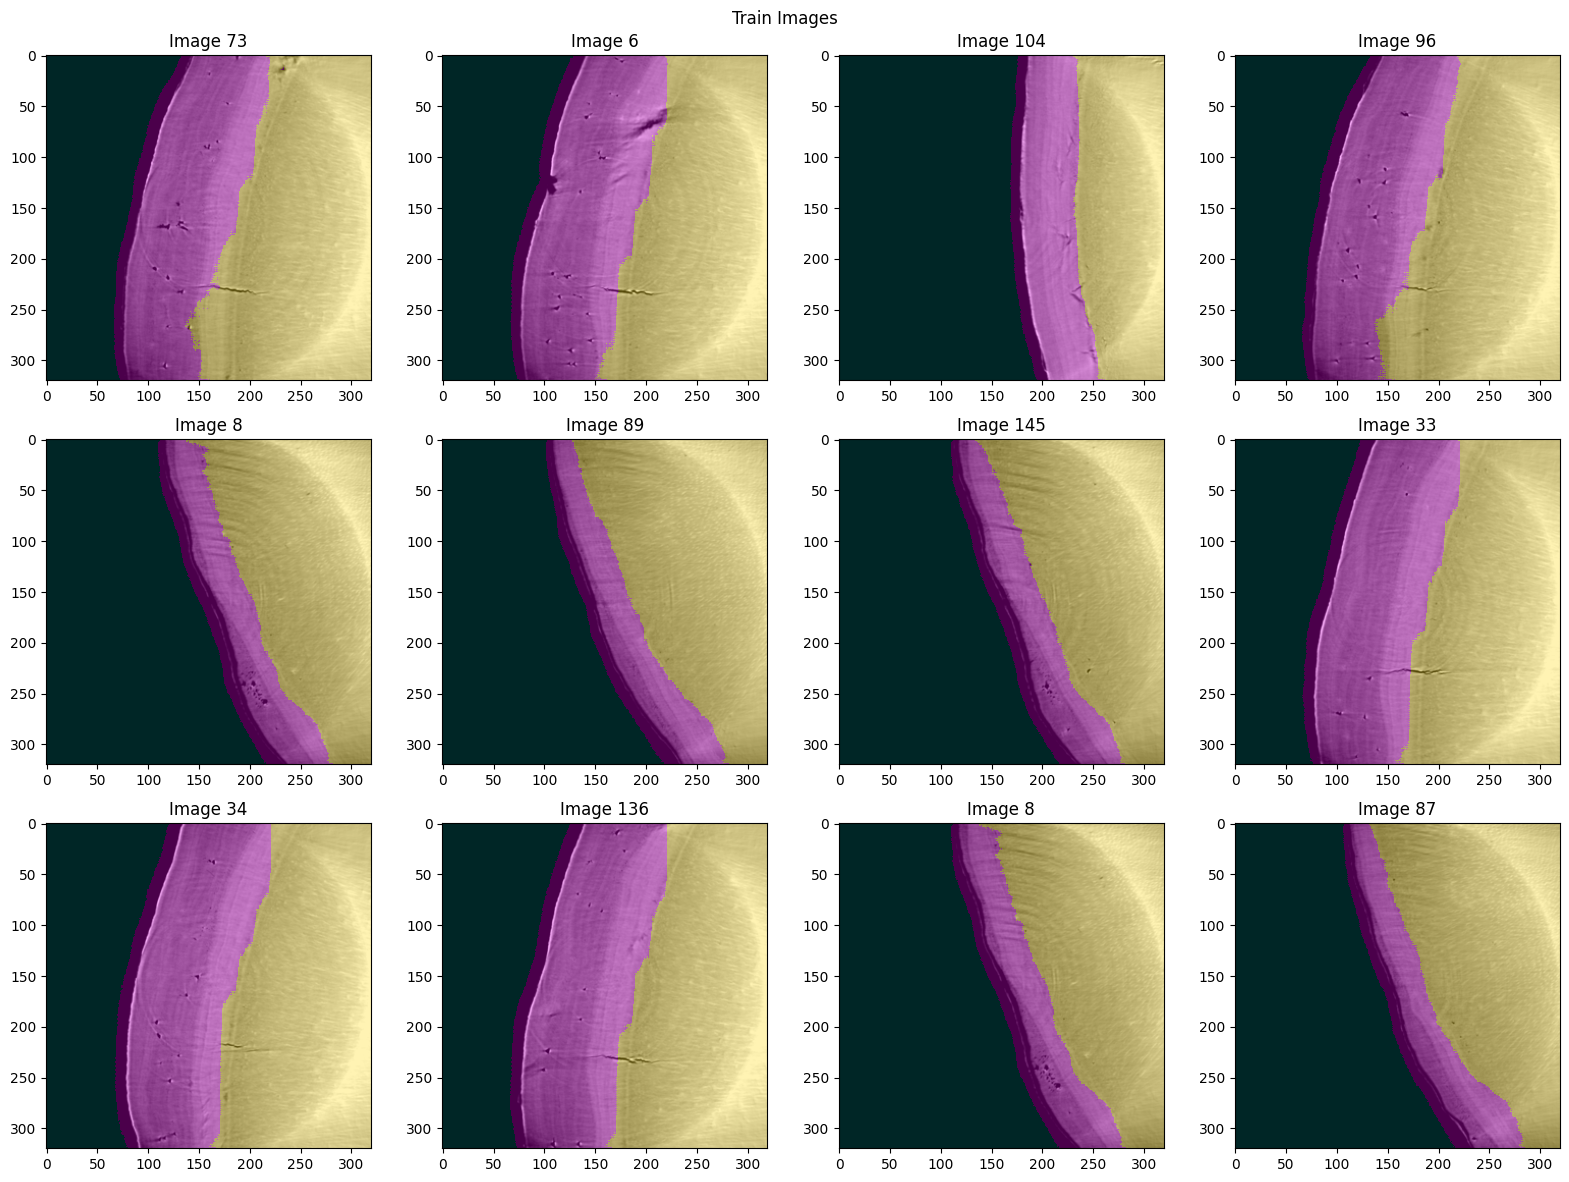

In [29]:
""" Show the prediction for some of the training images """
from matplotlib.colors import ListedColormap


def preprocess_image(image):
    # Add batch axis
    return image[np.newaxis, ...]


# Choose some images and masks at random
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
indices = np.random.randint(0, len(X_train), size=len(axes.ravel()))


def plot_predictions(axes, indices, images):
    cmap = ListedColormap(["teal", "magenta", "gold"])

    for index, axis in zip(indices, axes.ravel()):
        prediction = np.argmax(
            model.predict(preprocess_image(images[index]), verbose=0), axis=-1
        ).squeeze()
        axis.set_title(f"Image {index}")
        axis.imshow(images[index], cmap="gray")
        axis.imshow(prediction, cmap=cmap, alpha=0.3)


plot_predictions(axes, indices, X_train)
fig.suptitle("Train Images")
fig.tight_layout()

fig.savefig("training_predictions.png")

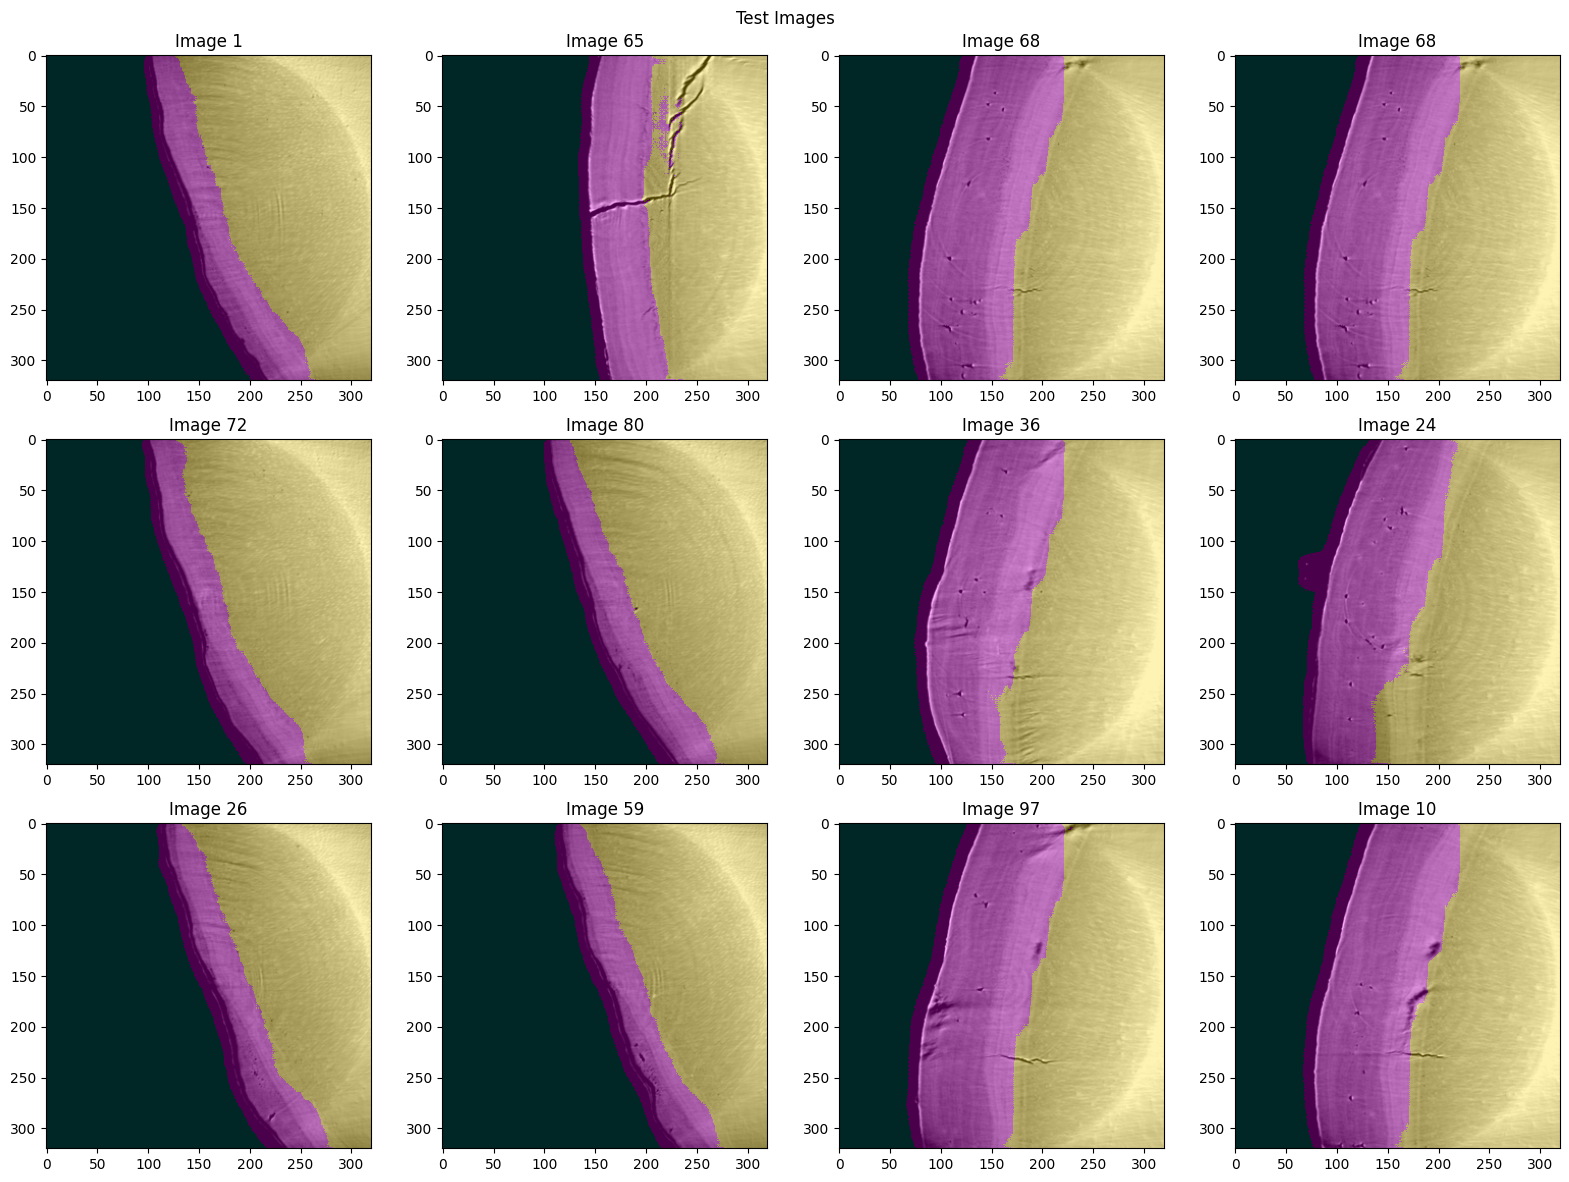

In [27]:
""" Show the prediction for some test images """

# Choose some images at random
indices = np.random.randint(0, len(X_test), size=len(axes.ravel()))

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
plot_predictions(axes, indices, X_test)

fig.suptitle("Test Images")
fig.tight_layout()
fig.savefig("test_predictions.png")

(600, 640)
[0 1 2]


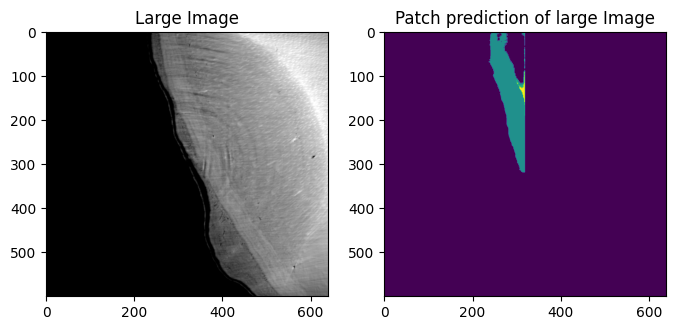

In [28]:
"""
Apply to one of the large images

"""
from patchify import patchify, unpatchify
from keras.utils import normalize

large_images = np.asarray(full_size_images)
large_image = large_images[1, :, :]
print(large_image.shape)

# This will split the image into small images of shape [3,3]
patches = patchify(
    large_image, (IMG_HEIGHT, IMG_WIDTH), step=IMG_WIDTH
)  # Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        single_patch = patches[i, j, :, :]
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1), 2)
        single_patch_input = np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = model.predict(single_patch_input, verbose=0)
        single_patch_predicted_img = np.argmax(single_patch_prediction, axis=3)[0, :, :]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(
    predicted_patches, (patches.shape[0], patches.shape[1], IMG_HEIGHT, IMG_WIDTH)
)

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title("Large Image")
plt.imshow(large_image, cmap="gray")
plt.subplot(222)
plt.title("Patch prediction of large Image")
print(np.unique(reconstructed_image))
plt.imshow(reconstructed_image)#, cmap="tab10")
plt.savefig("large_image.png")
plt.show()